In [1]:
library(tidyverse)
library(glue)
library(here)
library(furrr)
library(lemon)
library(cowplot)
    
devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

here() starts at /mnt/expressions/mp/archaic-ychr
Loading required package: future

Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading ychr


In [2]:
get_lengths <- function(bam) { 
    lengths <- paste("samtools view ", bam, " | awk '{print length($10)}'") %>%
        pipe %>%
        scan
    name <- basename(bam) %>% str_replace_all("^[a-z]+_|.bam$", "") %>% fix_name
    regions <- basename(bam) %>% str_replace_all("^([a-z]+)_.*", "\\1")
    
    tibble(name = name, regions = regions, length = lengths)
}

In [3]:
length_df <-
    list.files(here("data/bam"), ".bam$", full.names = TRUE) %>%
    str_subset("full_den4|full_den8|full_mez2[^_]|full_spy1|lippold_elsidron2") %>%
    future_map_dfr(get_lengths)

In [4]:
summary_df <- length_df %>%
    group_by(name) %>%
    summarise(mean = mean(length), median = median(length)) %>%
    arrange(mean) %>%
    mutate(mean = format(mean, digits = 3))

In [5]:
summary_df

name,mean,median
<chr>,<chr>,<dbl>
Denisova 8,44.8,42
Spy 94a,51.2,47
Mezmaiskaya 2,54.1,49
Denisova 4,54.1,50
El Sidrón 1253 (560 kb),55.3,51


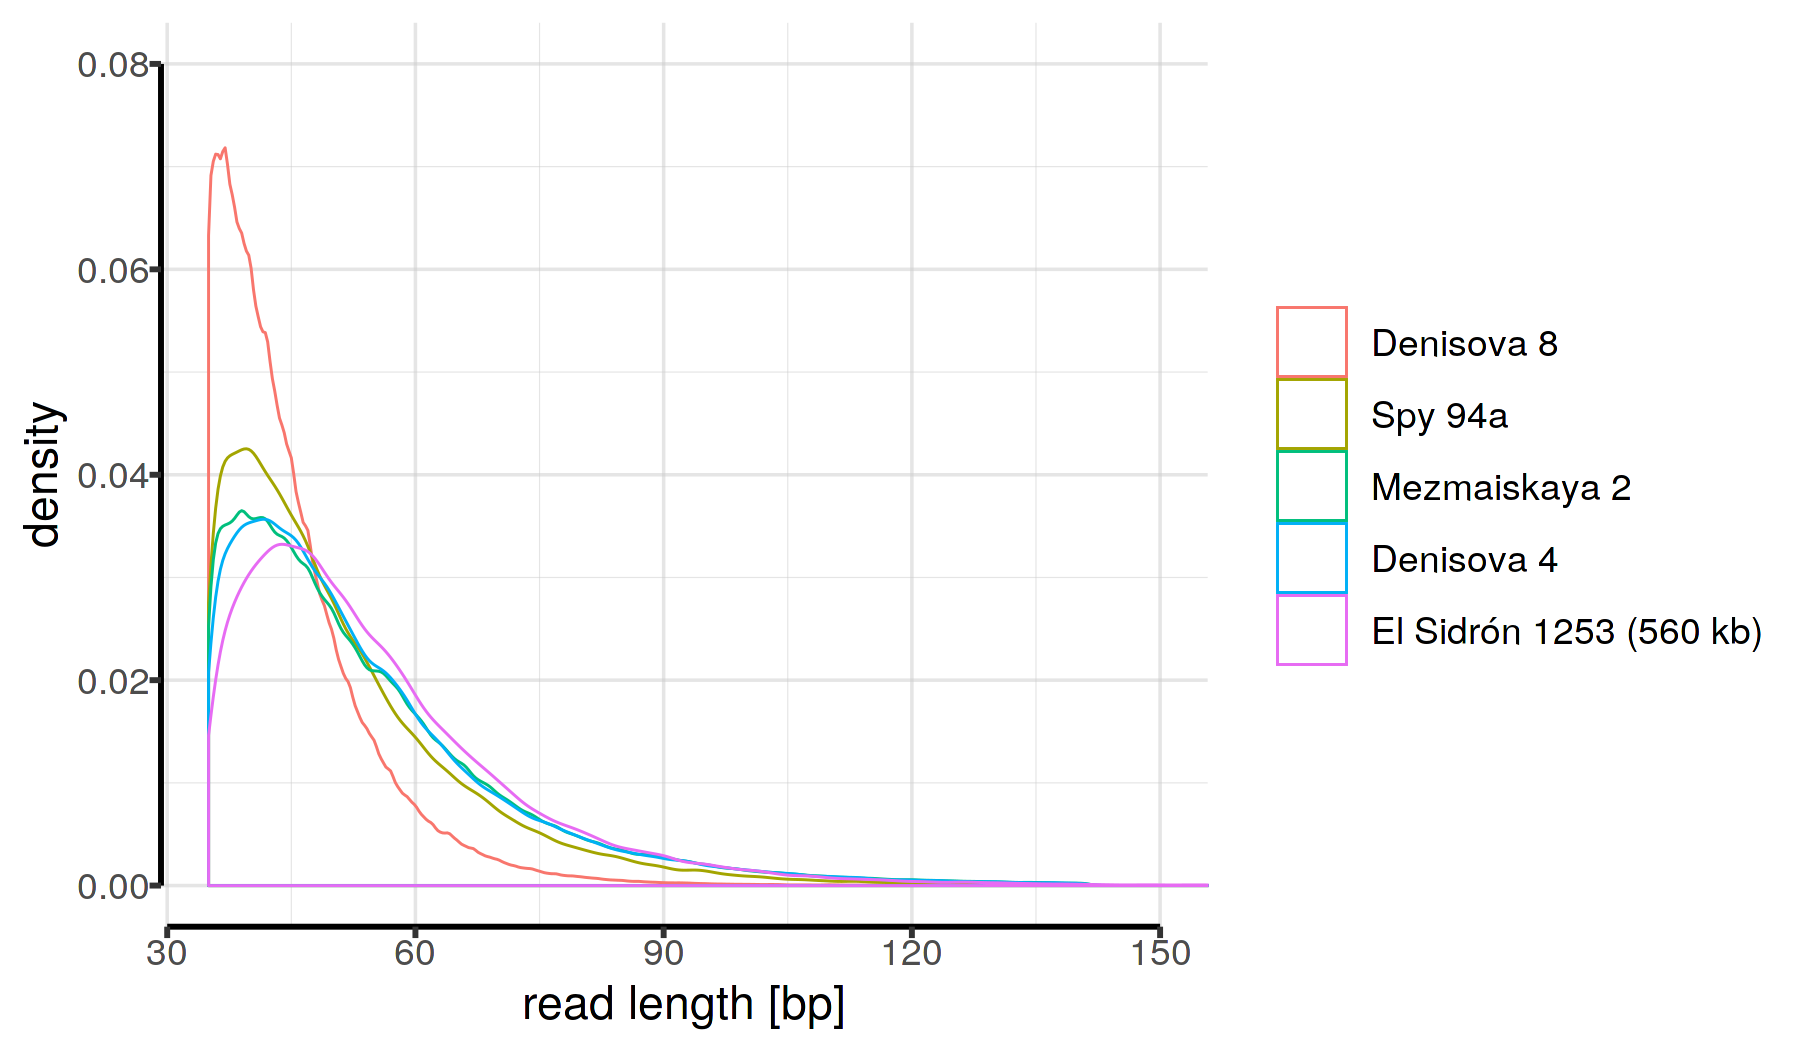

In [6]:
set_dim(6, 3.5)

length_df %>%
mutate(name = factor(name, levels = summary_df$name)) %>% 
ggplot(aes(length, color = name)) +
    geom_density(size = 0.25) +
    theme_classic() +
    coord_capped_cart(xlim = c(35, 150), ylim = c(0, 0.08), left = "both", bottom = "both") +
    theme(legend.title = element_blank(), plot.title = element_text(size = 12)) +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.5),
                    color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.5)) +
    xlab("read length [bp]")